In [151]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.backend import square, mean
import seaborn as sns

look_back = 48
num_epochs = 7
seq_len = 8
batch_size=256
loss="mse"
ewm=8

In [152]:
# def getDataset():
#     url = "./datasets/DAT_ASCII_EURUSD_M1_2017.csv"
#     df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
#     df.drop(columns=['open', 'high', 'low'], inplace=True)
#     df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
#     df.set_axis(df['date'], inplace=True)
#     df.drop(columns=["date"], inplace=True)
#     df["Close"]= df["close"] # compatibility
#     df["Volume"]= df["volume"] # compatibility
#     df.drop(columns=['close'], inplace=True)
#     return df

In [153]:
def getDataset():
    url = "./datasets/eurusd-m15-2018/EURUSD.csv"
    df = pd.read_csv(url)
    # df.drop("Volume", 1, inplace=True)
    df["Date"] = df["Date"].astype(str) + " " + df["Timestamp"]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index("Date", inplace=True)
    # df.drop("Date", 1, inplace=True)
    df.drop("Timestamp", 1, inplace=True)
    df.drop("Open", 1, inplace=True)
    df.drop("High", 1, inplace=True)
    df.drop("Low", 1, inplace=True)

    return df

In [154]:
df = getDataset()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,124644.0,1.128641,0.042777,1.03453,1.102260,1.122700,1.149012,1.255170
Volume,124644.0,2885.534891,3022.642481,0.75000,1235.079999,2199.809994,3503.077490,231774.848796


In [155]:
dflen=len(df)
df=df[:int(dflen/6)]
df= (df - df.mean())/df.std()
df.head()

,Close,Volume
Date,,
2015-01-25 22:00:00,0.228179,-0.922954
2015-01-25 22:15:00,0.245953,-0.916492
2015-01-25 22:30:00,0.271344,-1.050046
2015-01-25 22:45:00,0.249339,-1.028854
2015-01-25 23:00:00,0.247223,-0.225800


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd07be3f750>,
      dtype=object)

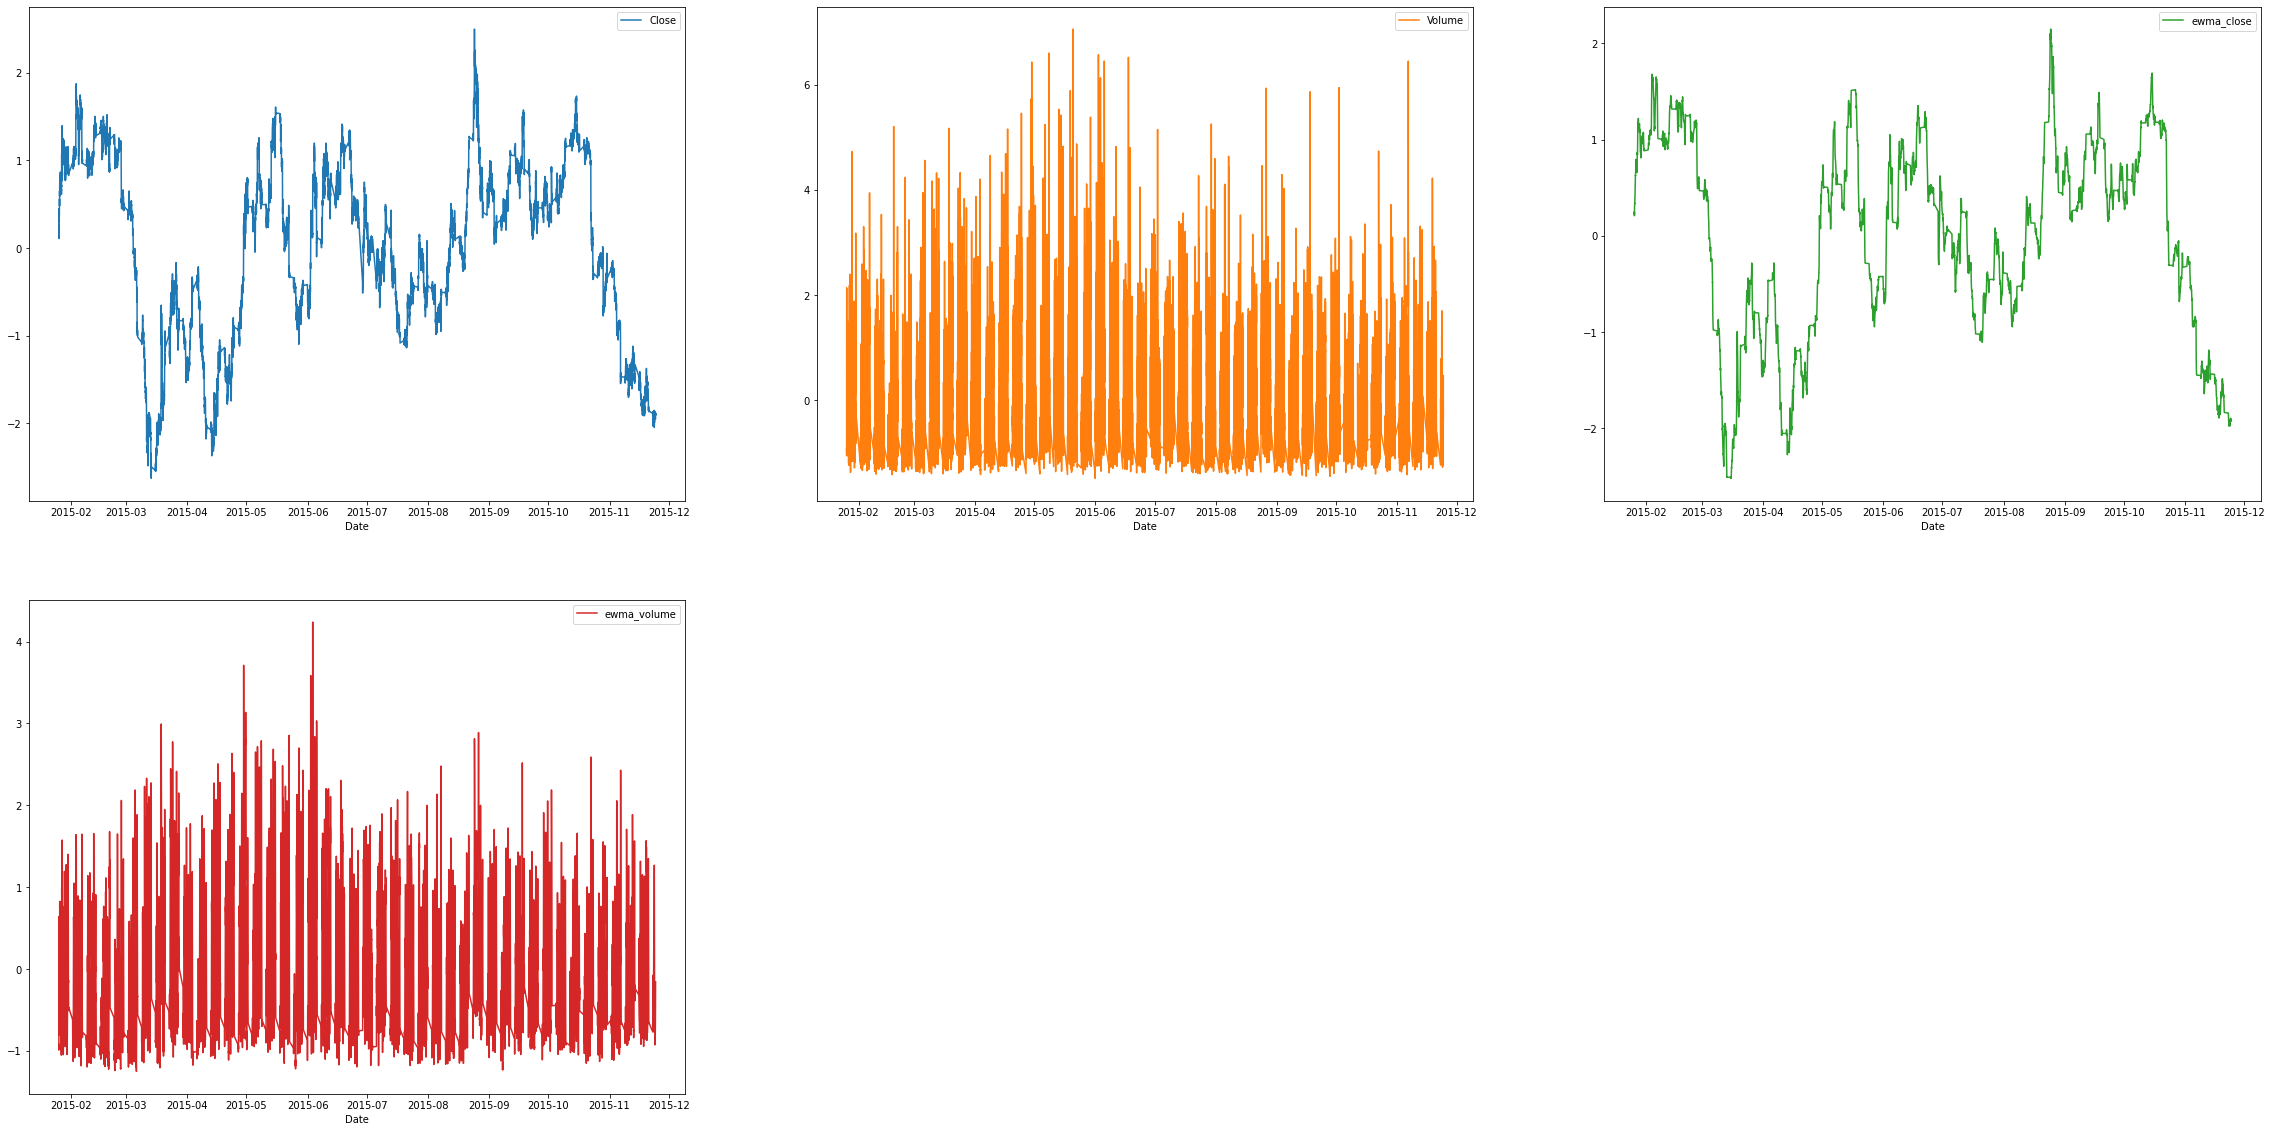

In [156]:
df["ewma_close"]=df["Close"].ewm(ewm).mean()
df["ewma_volume"]=df["Volume"].ewm(ewm/2).mean()
df.plot(subplots=True, layout=(2, 3), figsize=(40, 20), sharex=False)

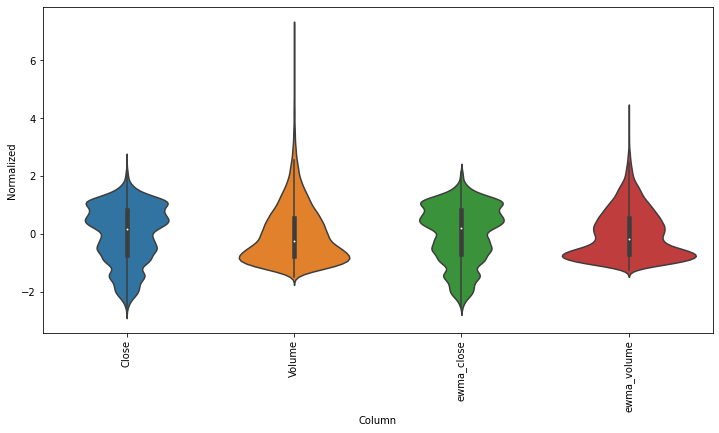

In [157]:
df_std = pd.melt(df, var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

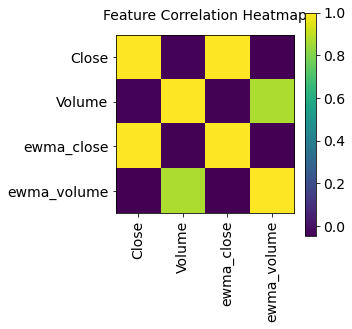

In [132]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

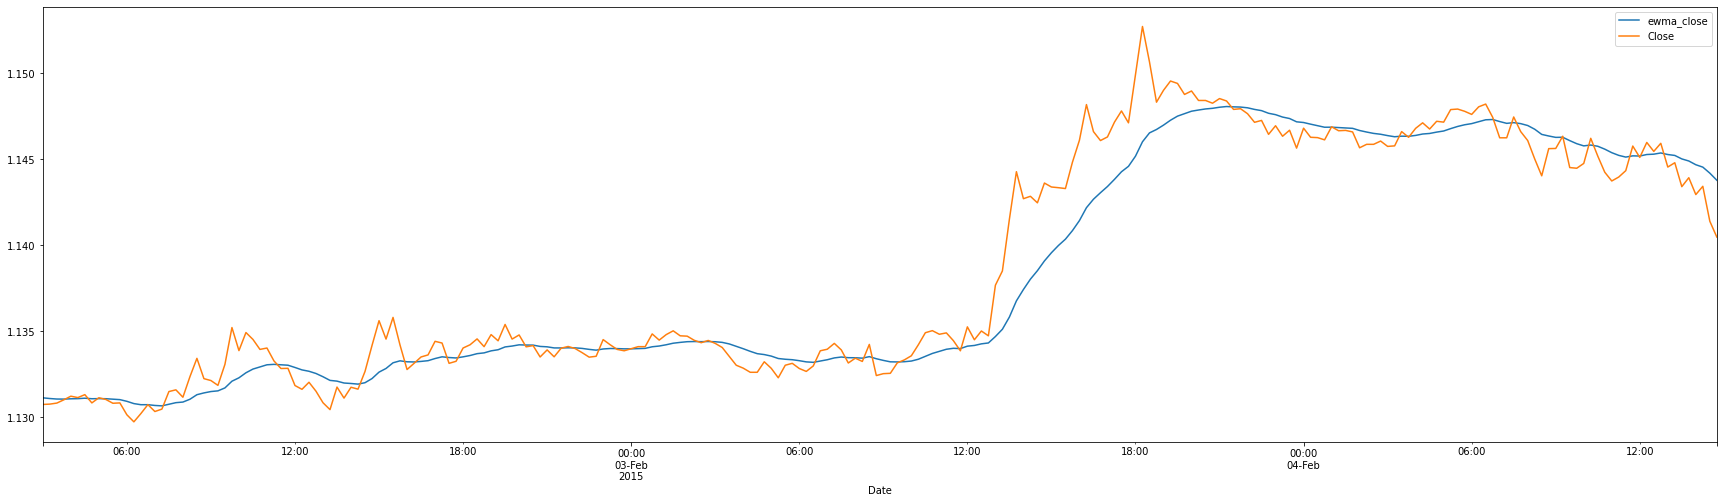

In [43]:
offset=500
df[["ewma_close", "Close"]][offset:offset+5*look_back].plot(figsize=(30,8))

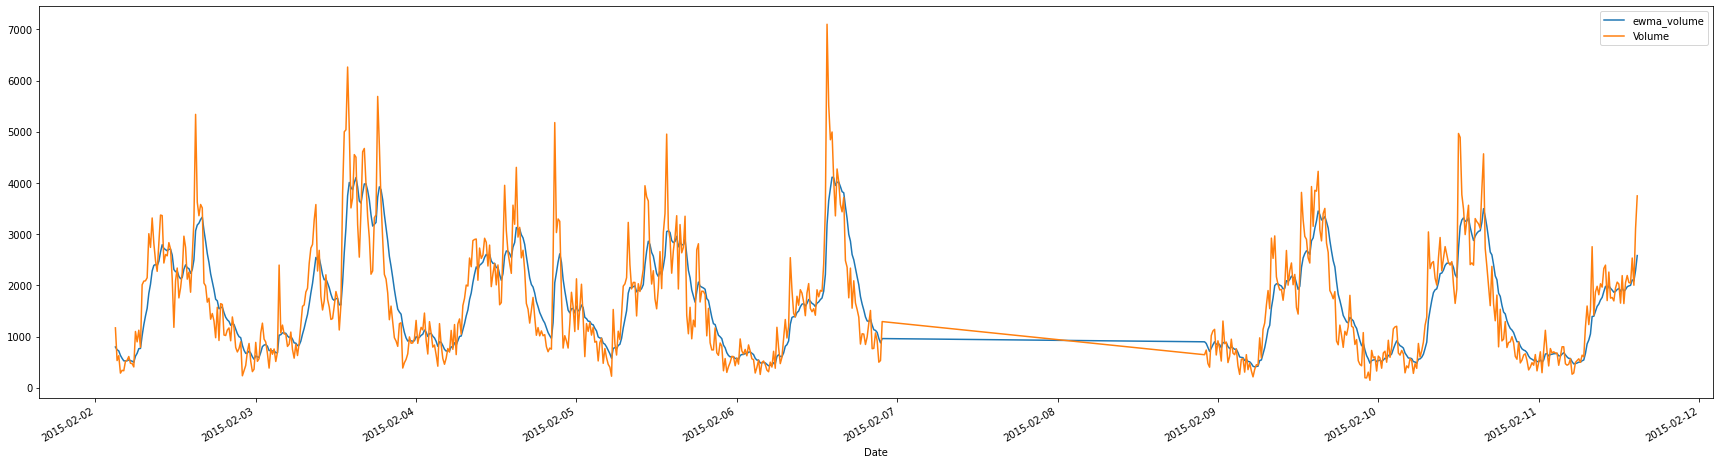

In [133]:
offset=500
df[["ewma_volume", "Volume"]][offset:offset+15*look_back].plot(figsize=(30,8))

In [49]:
data = df[['ewma_close', "ewma_volume"]].values

split_percent = 0.80
split = int(split_percent*len(data))

train_data = data[:split]
test_data = data[split:]

date_train = df.index[:split]
date_test = df.index[split:]

print(train_data.shape)
print(test_data.shape)

(16619, 2)
(4155, 2)


In [67]:
close_scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()
# y_close_scaler = MinMaxScaler()
# y_volume_scaler = MinMaxScaler()

volume_train_data=train_data[:, 1]
volume_test_data=test_data[:, 1]

close_train_data=train_data[:, 0]
close_test_data=test_data[:, 0]

volume_train_scaled = volume_scaler.fit_transform(volume_train_data.reshape(-1,1)).reshape(1, -1)[0]
volume_test_scaled = volume_scaler.fit_transform(volume_test_data.reshape(-1,1)).reshape(1, -1)[0]

close_train_scaled = close_scaler.fit_transform(close_train_data.reshape(-1,1)).reshape(1, -1)[0]
close_test_scaled = close_scaler.fit_transform(close_test_data.reshape(-1,1)).reshape(1, -1)[0]

train_data[:, 0] = close_train_scaled
train_data[:, 1] = volume_train_scaled

test_data[:, 0] = close_test_scaled
test_data[:, 1] = volume_test_scaled

In [75]:
def getY(data):
    X_train = []
    y_train = []
    for i in range(look_back, len(data)-seq_len):
        X_train.append(data[i-look_back:i])
        y_train.append(data[i:i+seq_len])
    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train

x_train,y_train=getY(train_data)
x_test, y_test=getY(test_data)

print(x_train.shape[1:])
print(y_train.shape)
print(x_train[0][:4])

(48, 2)
(16563, 8, 2)
[[0.58865858 0.05991675]
 [0.59067483 0.06057048]
 [0.59337465 0.05081784]
 [0.59332077 0.0473677 ]]


In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=1e-7)

model = Sequential()

units= look_back

# model.add(Bidirectional(GRU(units=64, return_sequences=True),input_shape=(x_train_scaled.shape[1], 1)))
model.add(GRU(units=units,input_shape=(None, 2), return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.15))

model.add(GRU(units=units))
# model.add(BatchNormalization())
# model.add(Dropout(0.15))

# model.add(GRU(units=16))
# model.add(BatchNormalization())
# model.add(Dropout(0.15))

model.add(Dense(units=seq_len, activation="relu"))
# model.add(Dropout(0.15))
model.add(Dense(units=1, activation="linear"))

optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss=loss)

In [130]:
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (None, None, 48)          7488      
_________________________________________________________________
gru_26 (GRU)                 (None, 48)                14112     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 392       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 22,001
Trainable params: 22,001
Non-trainable params: 0
_________________________________________________________________
None


In [131]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

history=model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test), batch_size=batch_size, shuffle=True, verbose=1, callbacks=[reduce_lr])

(16563, 48, 2)
(16563, 8, 2)
(4099, 48, 2)
(4099, 8, 2)
Epoch 1/7


InvalidArgumentError:  Incompatible shapes: [256,8,2] vs. [256,1]
	 [[node mean_squared_error/SquaredDifference (defined at <ipython-input-131-fdf9916c0f7d>:6) ]] [Op:__inference_train_function_39070]

Function call stack:
train_function


In [104]:
def plotHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['loss'], label='loss (training data)')
    ax.plot(history.history['val_loss'], label='loss (validation data)')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    ax.legend(loc="upper left")
    plt.title(f"loss = {loss}")
    plt.show()

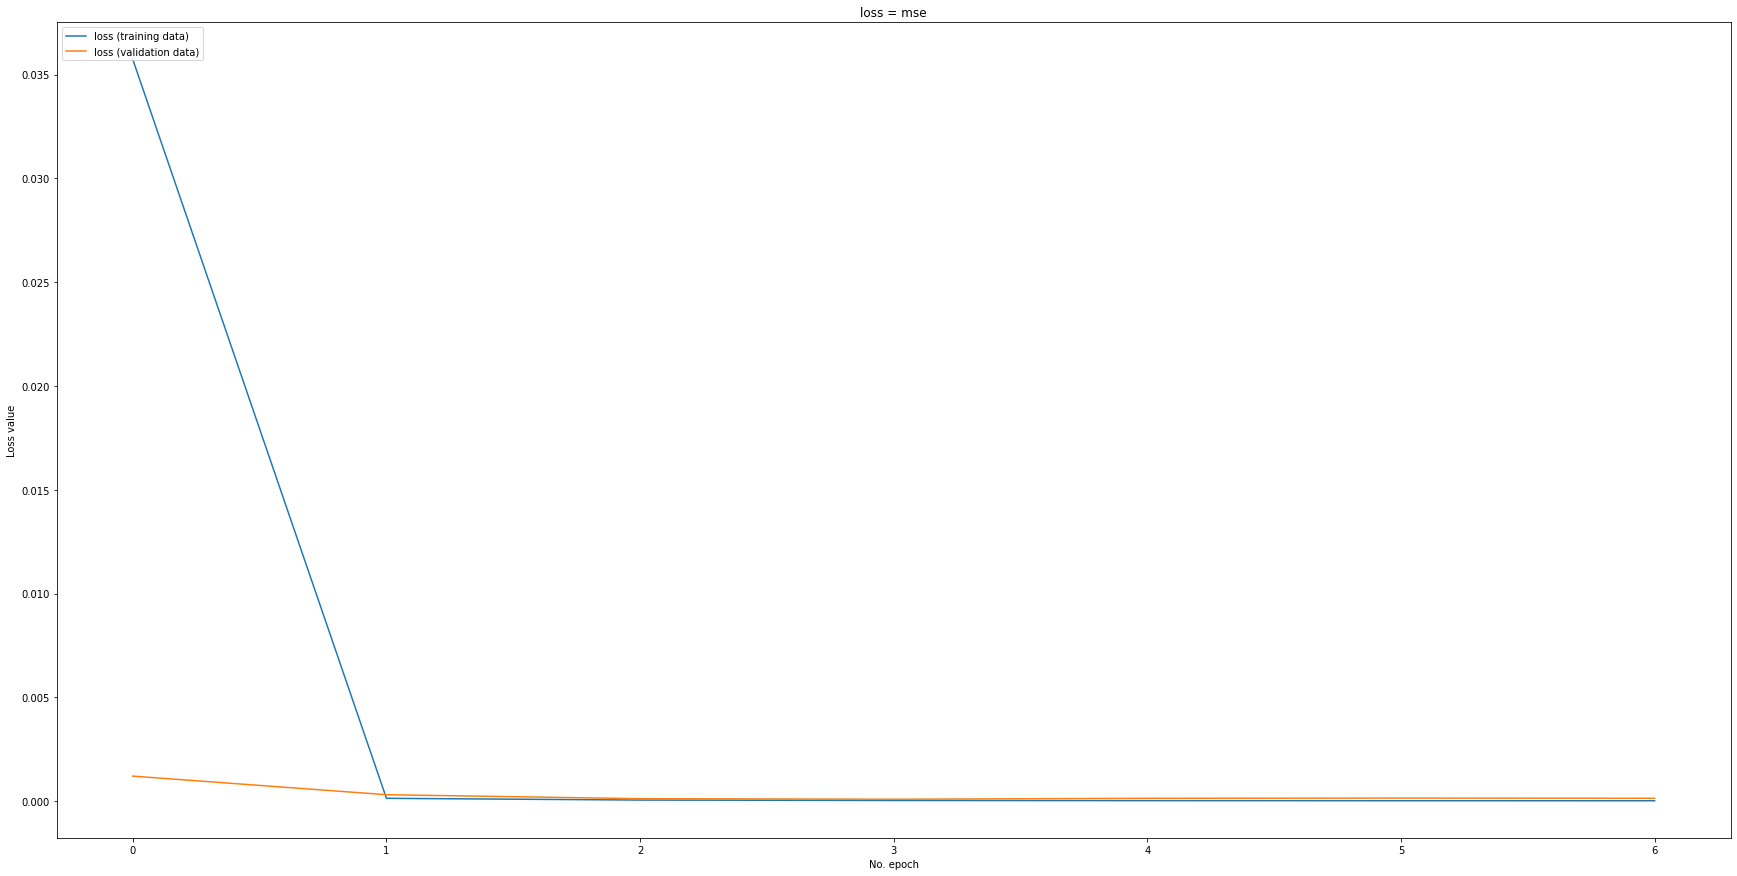

In [105]:
plotHistory(history)

In [106]:
def predictAndPlot(position=0, test=False, predictionPeriods=3):
    if test:
        x = x_test_scaled
    else:
        x = x_train_scaled

    prediction_list = np.array([x[position]])
    output=[]

    for i in range(predictionPeriods):
        y = model.predict(prediction_list).reshape(1,-1)[0]
        output.append(y)

        tmp = np.append(prediction_list[0].reshape(1,-1)[0],y)[-look_back:]
        predition_list = tmp.reshape(1, look_back, 1)

    pltx=x[position]
    pltx_unscaled = x_scaler.inverse_transform(pltx).reshape(1,-1)[0]
    
    plty=y_scaler.inverse_transform(np.array(output)).reshape(1,-1)[0]
    
    next_pltx = x_scaler.inverse_transform(x[position+len(pltx)]).reshape(1,-1)[0]

    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(pltx_unscaled, label='Base', color='orange')
    ax.plot([i for i in range(len(pltx), len(plty)+len(pltx))],plty, label='Predicted', color = 'blue')
    ax.plot([i for i in range(len(pltx), 2*len(pltx))], next_pltx, label='Next base', color = 'green')
#     ax.plot([i for i in range(0, 2*len(pltx))], df["Close"][position:][:2*len(pltx)],"g^", label='Original data', color = 'green')
    plt.xlabel('krok czasu')
    plt.ylabel('Stosunek euro/usd')
    # plt.savefig(f"pngs/cf{}")
    ax.legend()
    plt.show() 

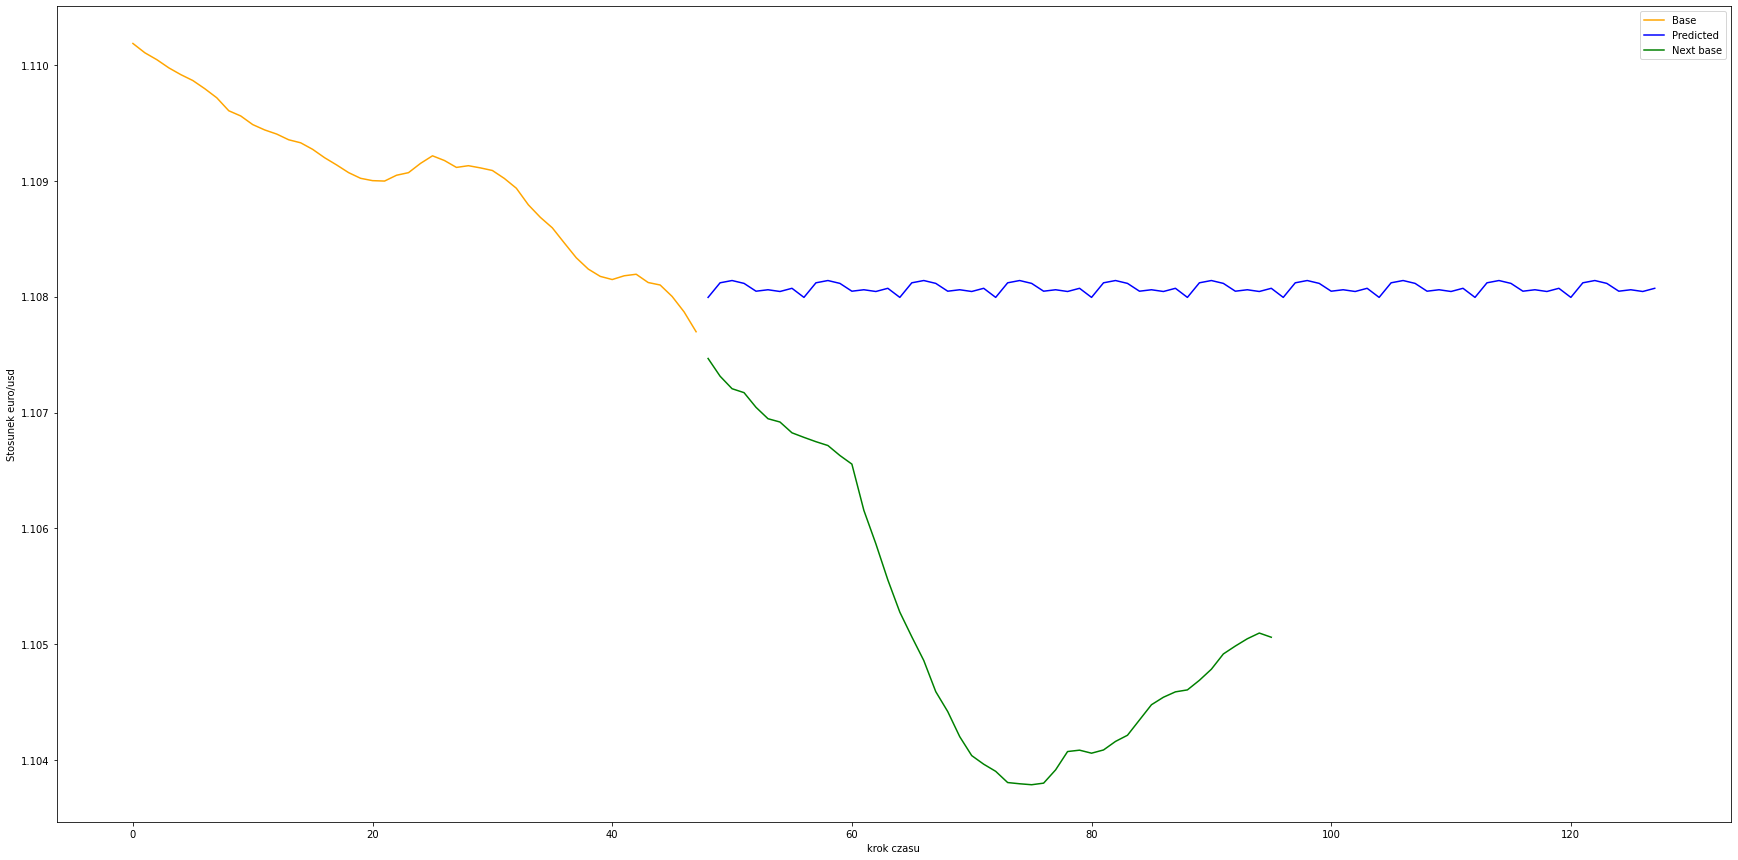

In [107]:
predictAndPlot(8000, True, 10)

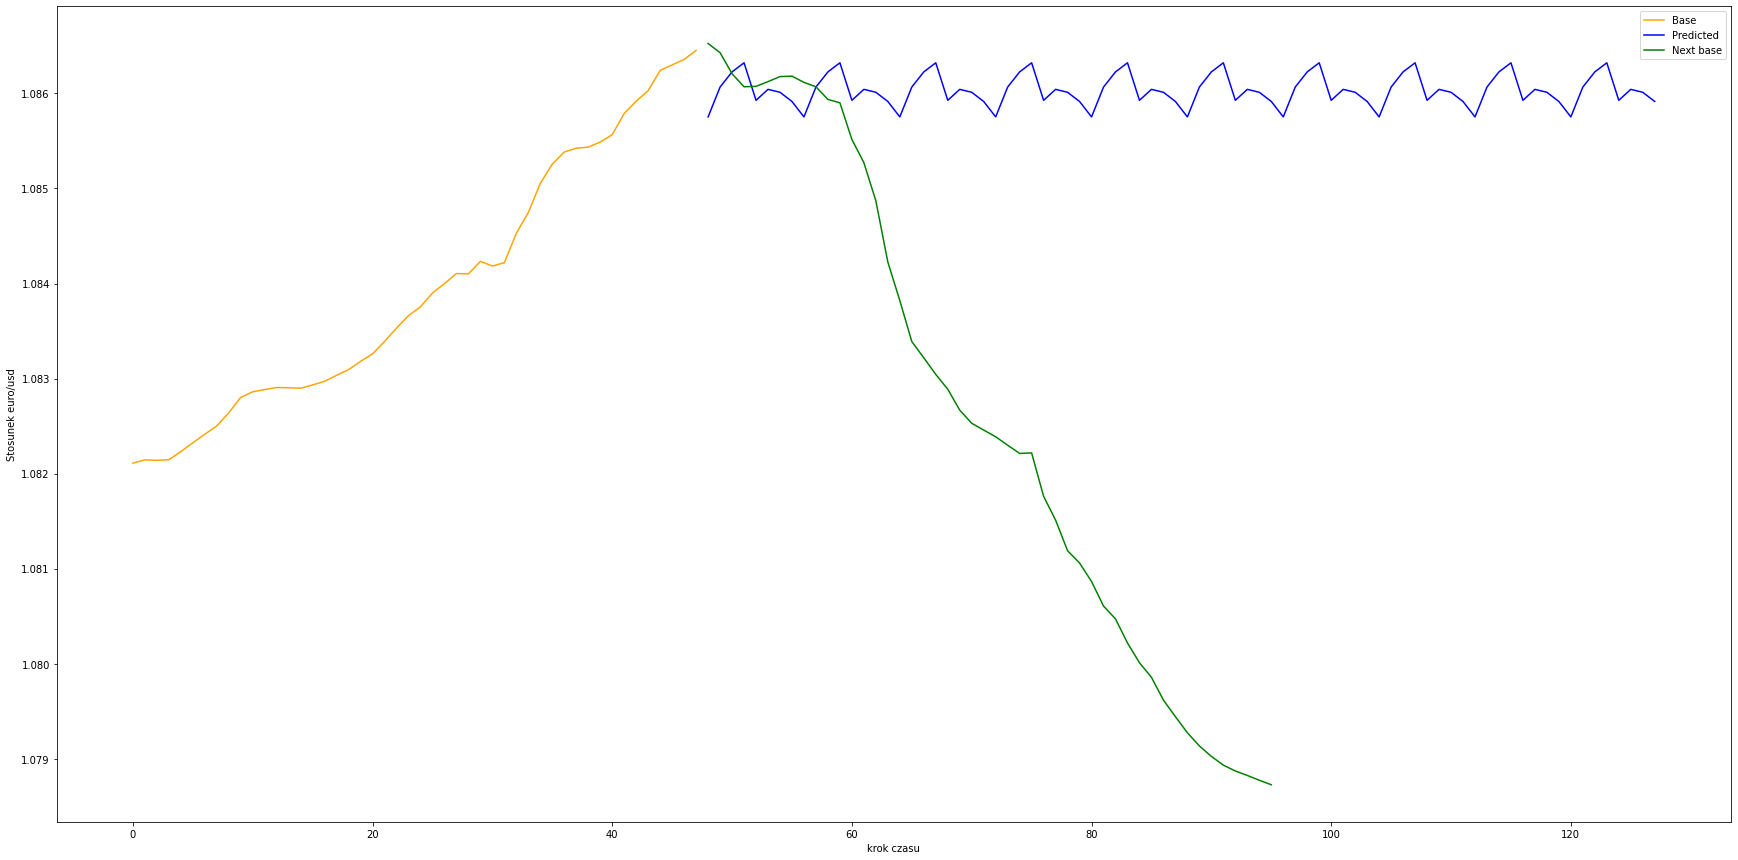

In [108]:
predictAndPlot(5000, False, 10)     

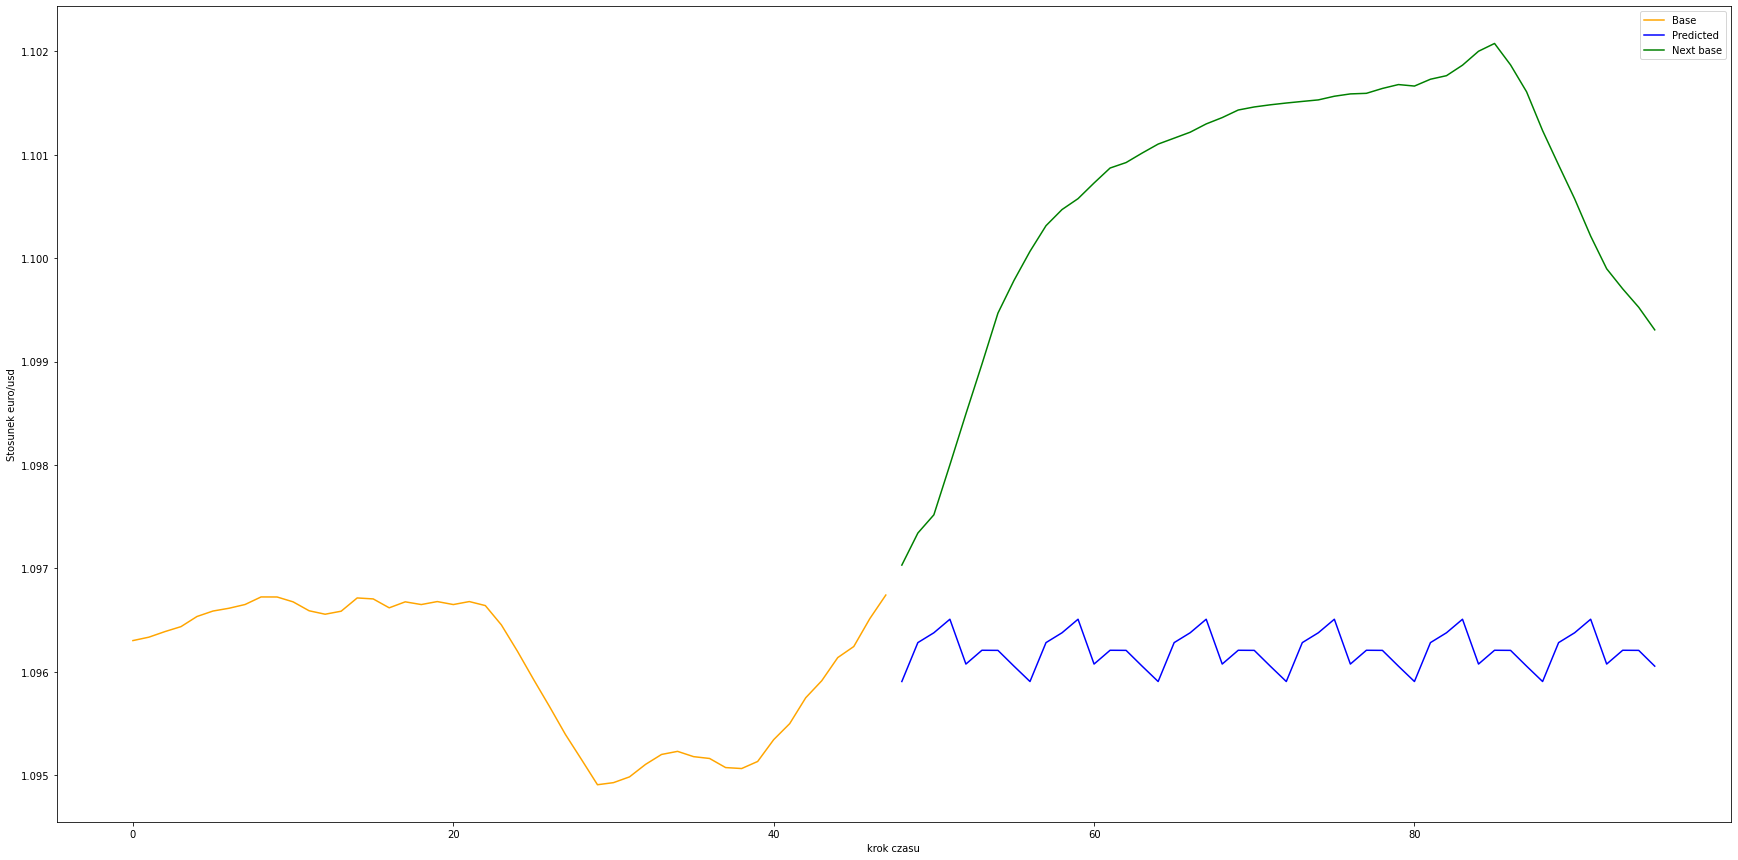

In [109]:
predictAndPlot(1000, True, 6)

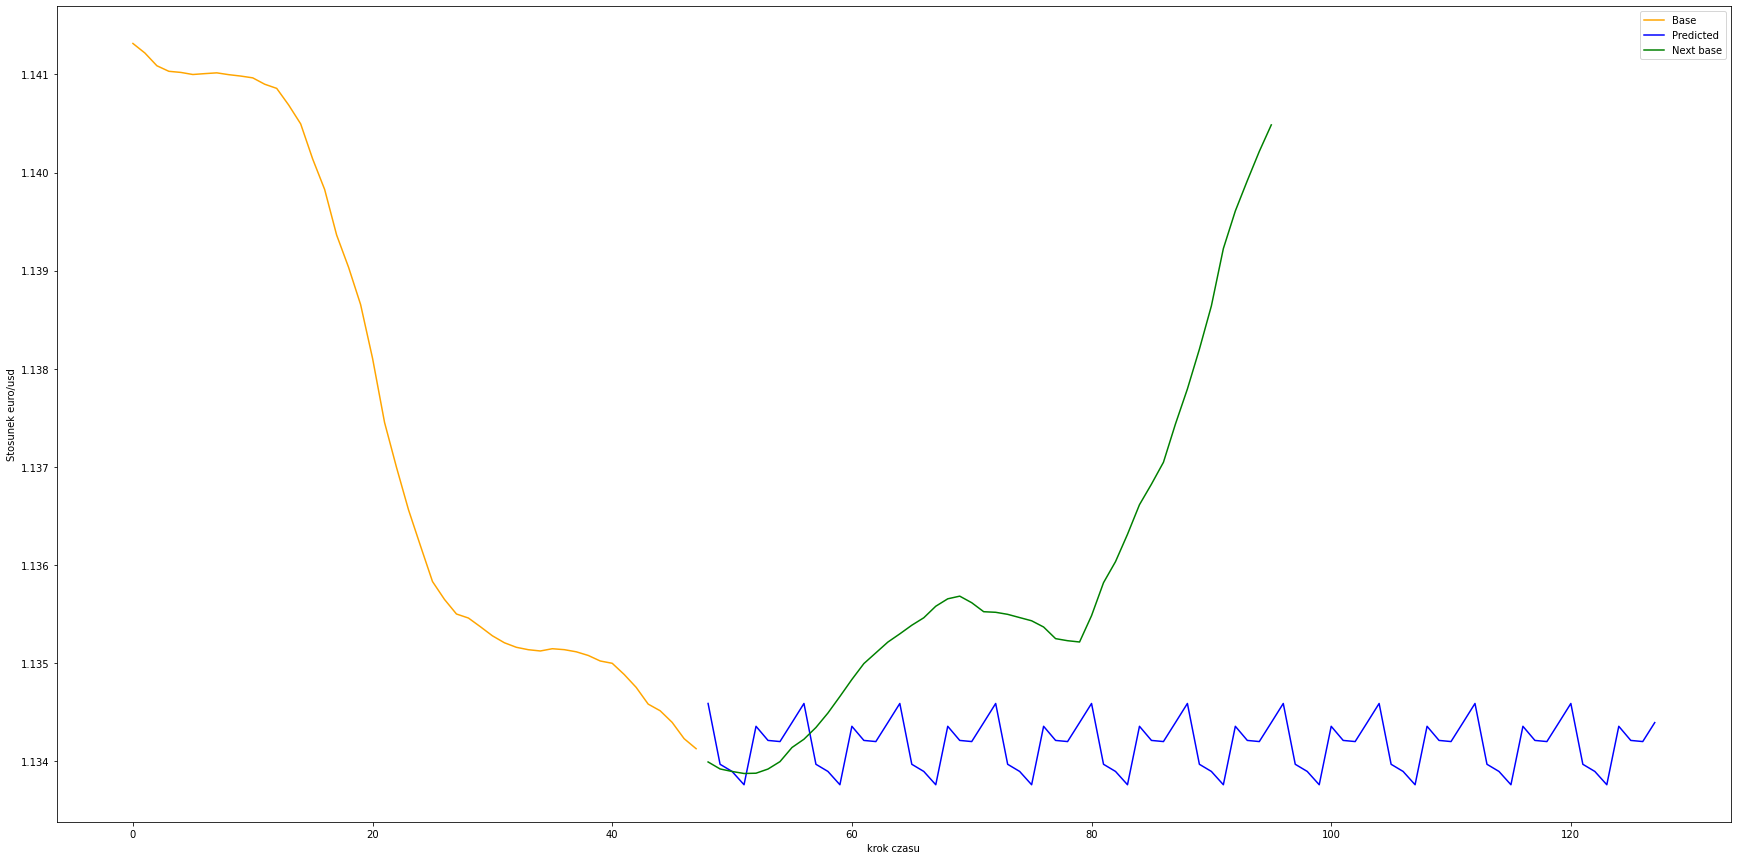

In [110]:
predictAndPlot(1500, False, 10)

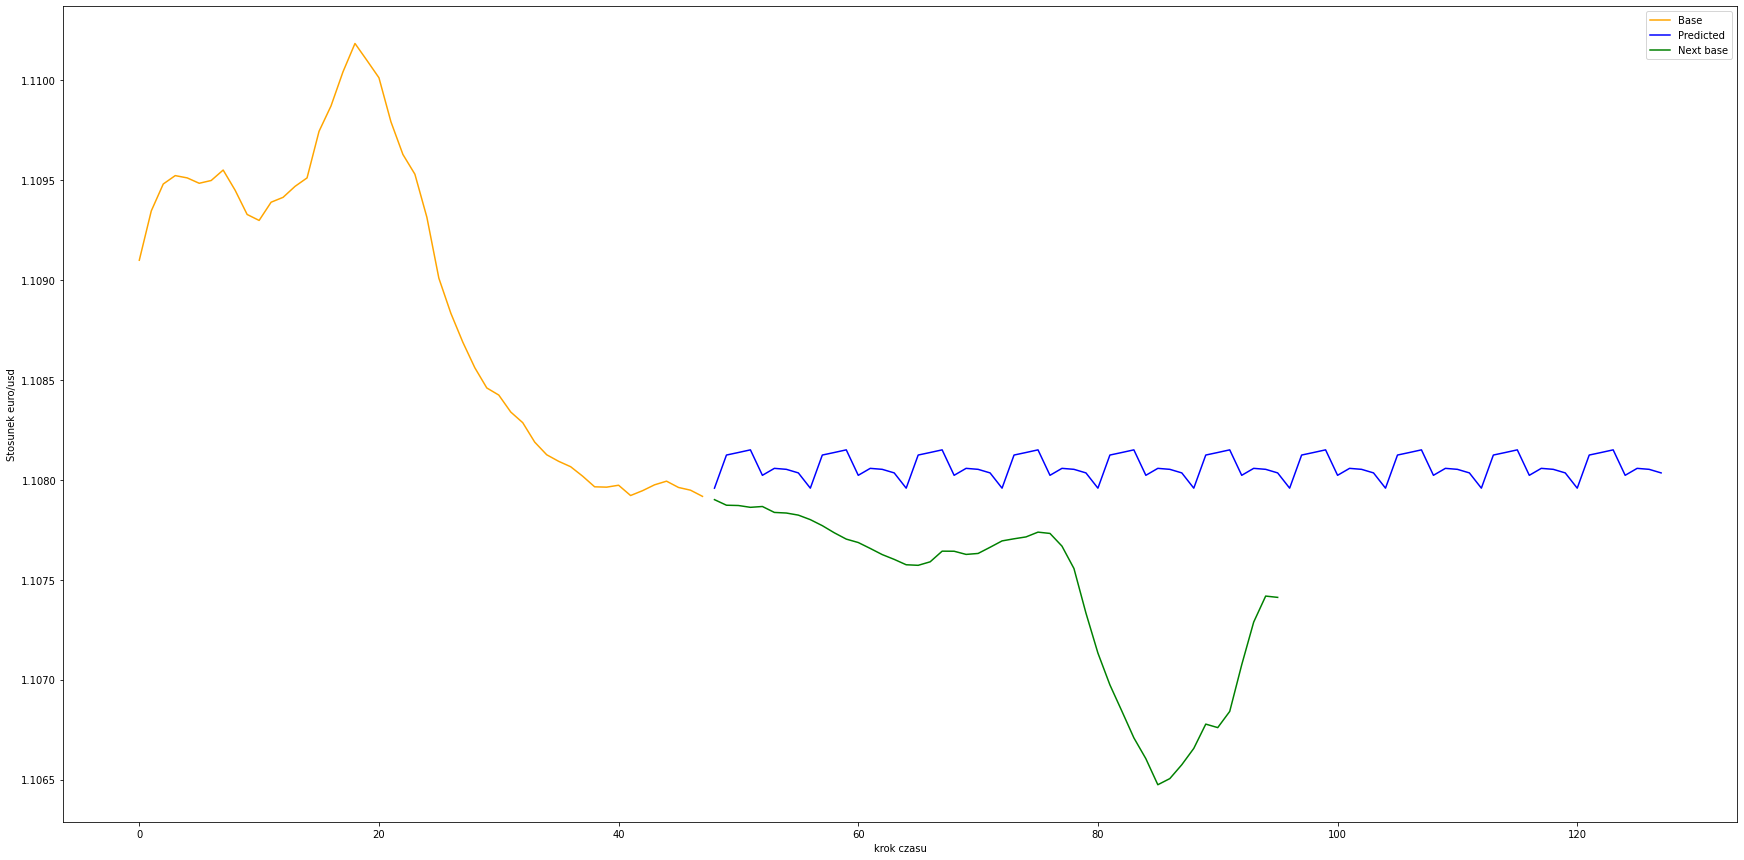

In [111]:
predictAndPlot(1500, True, 10)

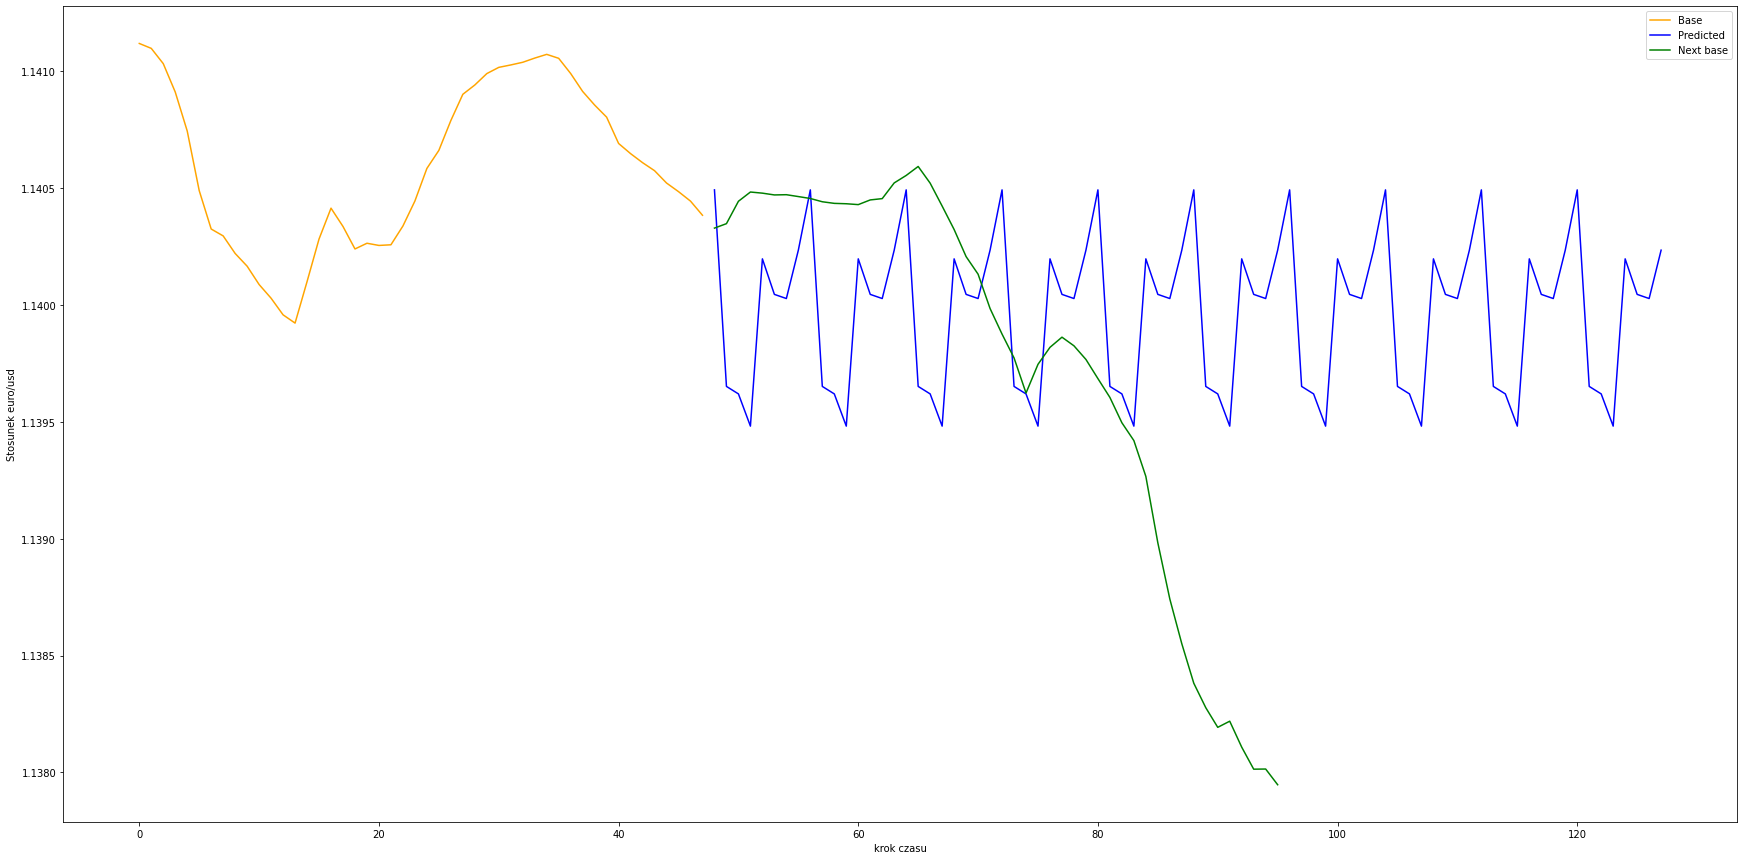

In [112]:
predictAndPlot(1600, False, 10)

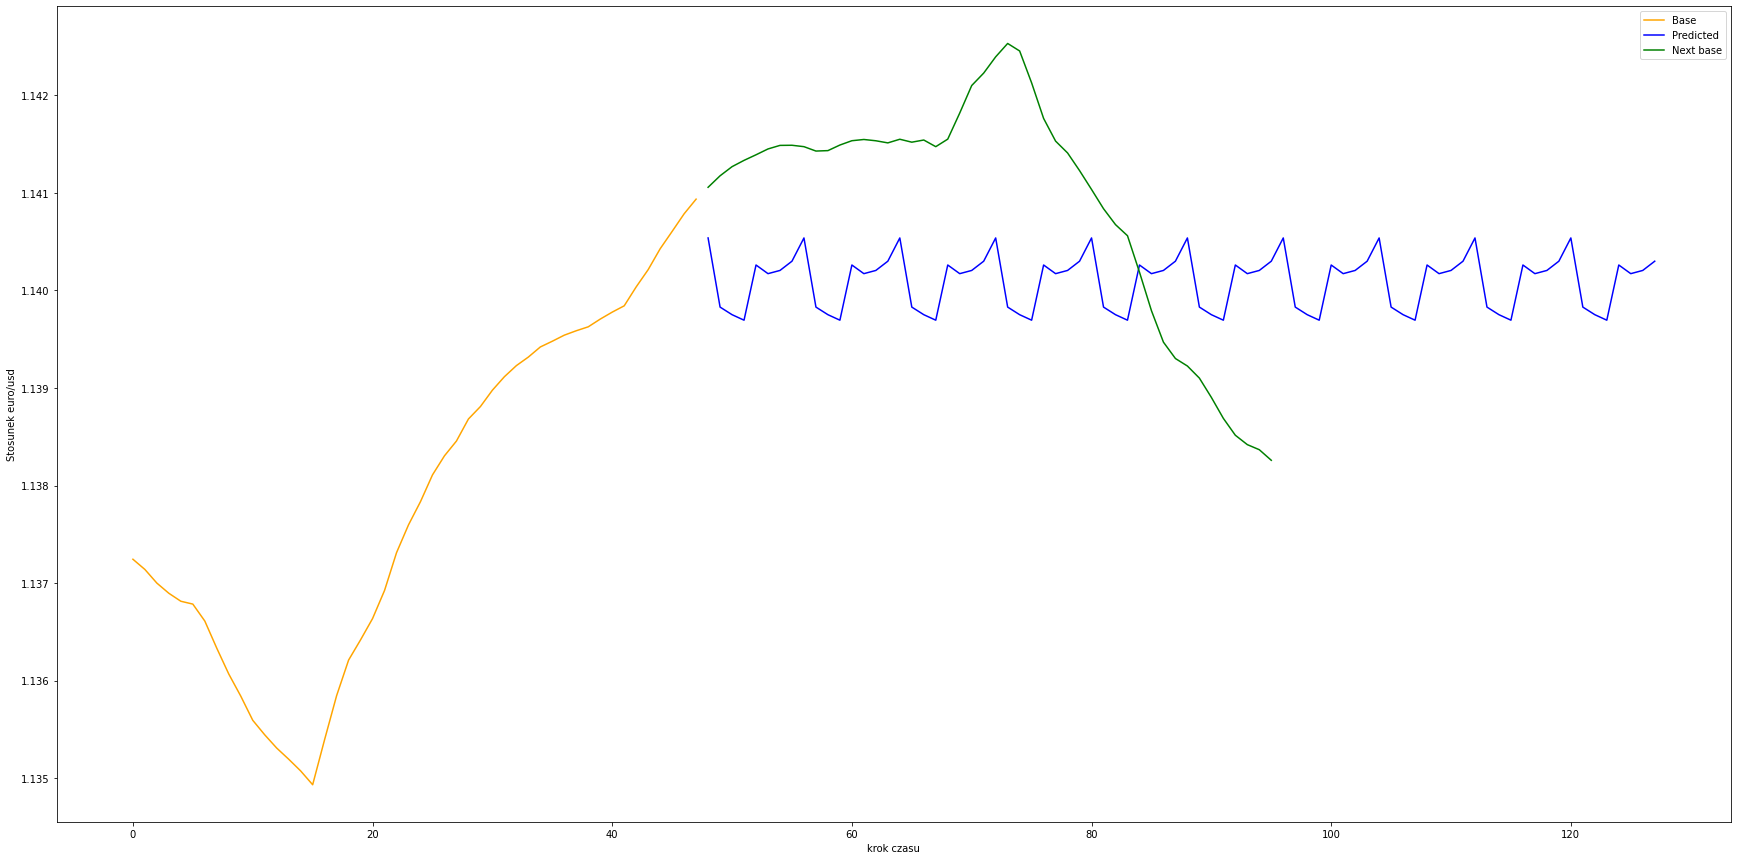

In [113]:
predictAndPlot(1700, False, 10)

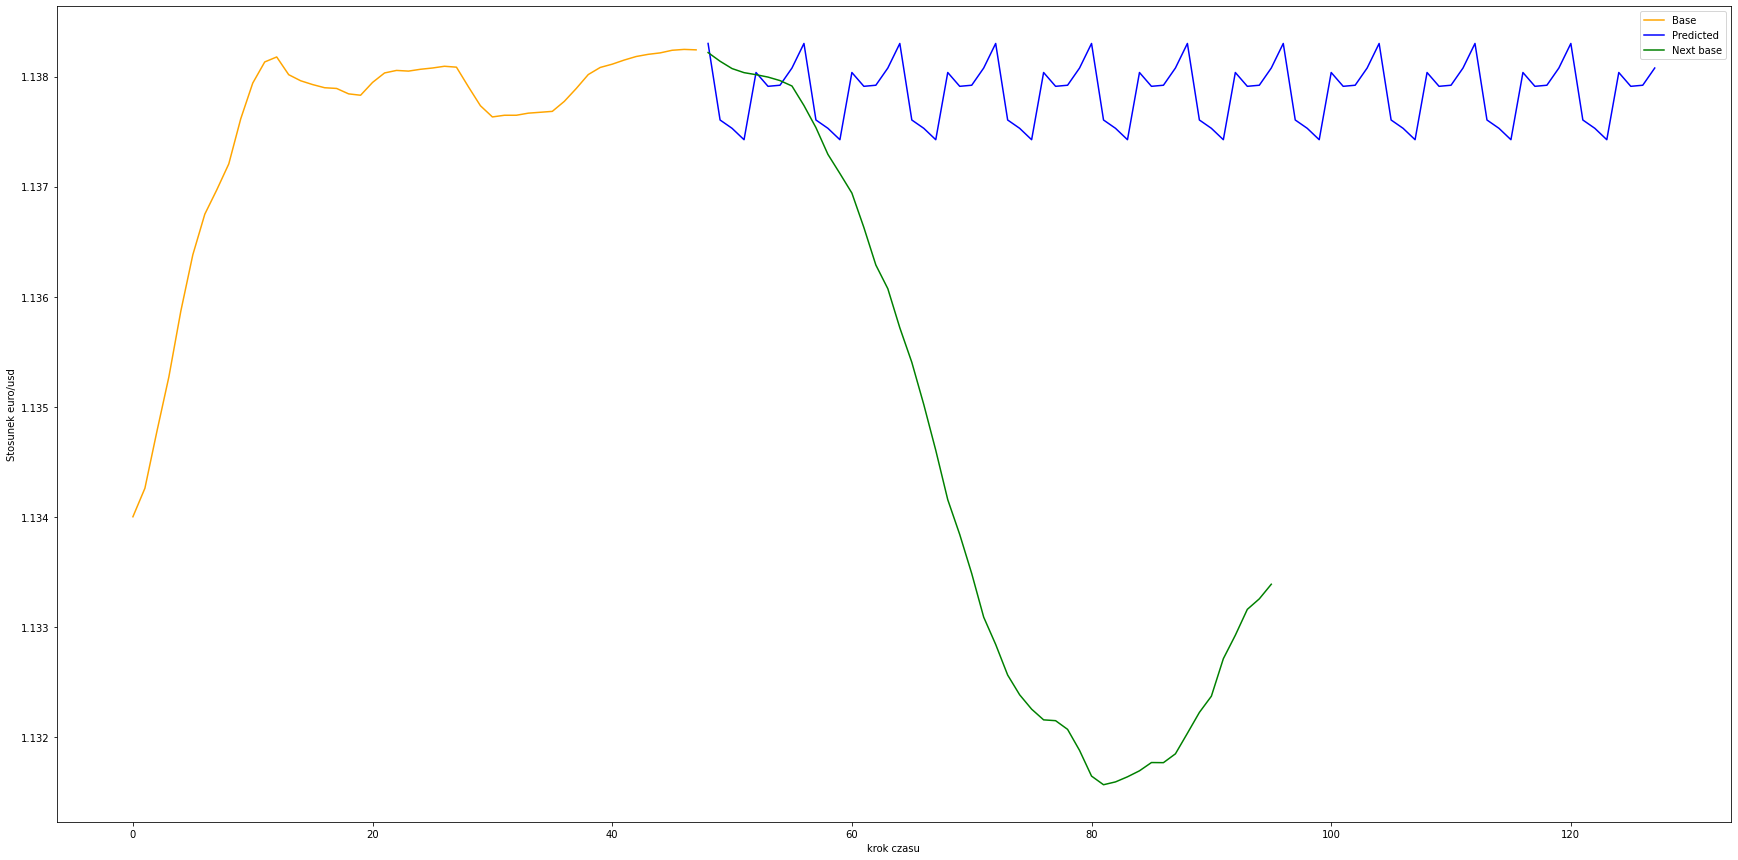

In [114]:
predictAndPlot(1900, False, 10)